Import some libraries we'll use:

In [1]:
import urllib.request
import gzip
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree  

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # larger plots

# Get NOAA weather stations

First, let's get the [list of NOAA weather stations](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt) so that we have a lat/lon location for each:

In [2]:
file = 'ghcnd-stations.txt'

if os.path.isfile(file):
    print('Stations already downloaded, using local file.')
else:
    print('Using online stations file directly.')
    file = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'

# we are using 100000 rows here to let pandas figure out the column widths - this is a bit slower, 
# but makes sure that we get all the stations way out west or south correctly without chopping of the minus sign 
stations = pd.read_fwf(file, 
            infer_nrows=100000, # how many rows to use to infer the column widths
            usecols = [0,1,2,3,5],
            names = ["station", "lat", "lon", "elevation", "name"])

stations.head()

Stations already downloaded, using local file.


,station,lat,lon,elevation,name
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL


Check the range of the lat and lon columns to make sure the coordinates have been parsed correctly:

In [3]:
print(f'Lats go from {stations.lat.min()} to {stations.lat.max()}')
print(f'Lons go from {stations.lon.min()} to {stations.lon.max()}')

Lats go from -90.0 to 83.65
Lons go from -179.983 to 179.32


Pull out the country ID from the station column (first two letters):

In [4]:
stations["country"] = stations["station"].astype(str).str[0:2]
stations.head()

,station,lat,lon,elevation,name,country
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE


Since the GHSL data we'll be using later is in Mollweide projection, we'll need to [project](https://github.com/pyproj4/pyproj) the lat/lon to the World Mollweide projection that the raster uses and pick up the values at those projected coordinates:

In [6]:
file = 'stations_moll.csv'

if os.path.isfile(file):
    print('Stations already projected to Mollweide, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    inProj = Proj(init='epsg:4326')   # lat/lon 
    outProj = Proj('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs', preserve_flags=True) # Mollweide

    projectedLocations = []

    # go through the list of stations and project each one to Mollweide
    for index, station in stations.iterrows():
        projectedLocations.append((transform(inProj,outProj,station['lon'],station['lat'])))

    # add the projected coordinates back to the stations dataframe
    stations['mollX'], stations['mollY'] = zip(*projectedLocations)  # 'unzip' with the *
    stations.to_csv(file)


stations.head()

Stations already projected to Mollweide, using local file.


,station,lat,lon,elevation,name,country,mollX,mollY
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06


# Spatial Index

Next, we'll build a spatial index of the stations, so we can quickly look up the nearest neighbors of any station. We'll be using the [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html) (based on [this hint](https://gis.stackexchange.com/a/301935/33224).). For that, we'll pull out just the Mollweide coordinates and build the index based on those (otherwise SciPy will make a multidimensional index using all columns):

In [7]:
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Let's try to find the closest stations to a specific one by name:

In [8]:
def queryStation(stationID, stations, stationsIndex, k=1):
    queryCoords = stations[stations.station==stationID][['mollX','mollY']].values
    dd, ii = stationsIndex.query(queryCoords, 
                             k=range(2,2+k), # start at 2, otherwise we get the station itself as first result
                             n_jobs=-1,      # use all CPUs
                             p=2   )         # p-norm 2 = euclidian distance
    
    knn = stations.iloc[ii[0]]
    knn = knn.copy()  # otherwise we might be modifying the stations dataframe...
    knn['distance'] = dd[0]
    return knn

Test:

In [9]:
stationID = 'RQC00663871'   # GARZAS station
queryStation(stationID, stations, stationsIndex, k=5)

,station,lat,lon,elevation,name,country,mollX,mollY,distance
47206,RQC00660053,18.1614,-66.7222,506.0,ADJUNTAS 1 S,RQ,-6.479289e+06,2.231113e+06,1924.820868
47331,RQC00668684,18.1333,-66.7333,868.7,SALTILLO 2 ADJUNTAS,RQ,-6.481011e+06,2.227706e+06,2060.888936
47266,RQC00664614,18.1506,-66.7719,2.7,HUMACAO NATURAL RESERVE,RQ,-6.484363e+06,2.229804e+06,3735.475164
47207,RQC00660061,18.1747,-66.7978,557.8,ADJUNTAS SUBSTN,RQ,-6.486324e+06,2.232726e+06,6435.610695
47309,RQC00666982,18.0833,-66.7333,349.9,PENUELAS SALTO GARZAS,RQ,-6.482155e+06,2.221642e+06,8231.252200


# Get [GHSL population data](https://ghsl.jrc.ec.europa.eu/ghs_pop.php) for 1975

Download dir at http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/

In [10]:
file = 'GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif'

if os.path.isfile(file):
    print('GHSL population data for 1975 already downloaded.')
else:
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW41975_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file)
    
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip')
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif.ovr')

GHSL population data for 1975 already downloaded.


We'll use the data to assign each station an estimate of the population density in the GHSL cell that it is in. Since GHSL is in an equal area projection (i.e. all cells have the same area), we can safely do that.

We'll use [rasterio's sample method](https://gis.stackexchange.com/questions/190423/getting-pixel-values-at-single-point-using-rasterio) for that. Let's read in the GeoTIFF first:

In [11]:
pop1975 = rio.open(file)
pop1975

<open DatasetReader name='GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif' mode='r'>

In [12]:
pop1975.bounds

BoundingBox(left=-17619594.54744353, bottom=-6484970.538131511, right=17877405.45255647, top=8750529.46186849)

In [13]:
pop1975.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 141988,
 'height': 60942,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(250.0, 0.0, -17619594.54744353,
        0.0, -250.0, 8750529.46186849)}

To get values at point locations, we can simply pass a list of ```(x,y)``` tuples and rasterio will return a list of values at those points:

In [14]:
for val in pop1975.sample([(8432553,2759349)]):
    print(val)

[2680.5662]


Check that all coordinates are in the raster's bounding box:

In [15]:
print(min(stations['mollX']) > pop1975.bounds.left)
print(max(stations['mollX']) < pop1975.bounds.right)

print(min(stations['mollY']) > pop1975.bounds.bottom)
print(max(stations['mollY']) < pop1975.bounds.top)

True
True
False
False


Okay, so there are some stations North and South of our raster. Remove the stations that are outside of our raster bounding box (they are not really useful for our UHI analysis anyway, and [rasterio seems trip over them](https://gis.stackexchange.com/questions/323481/error-using-rasterios-sample-method)):

In [16]:
print(f'Before removal: {len(stations.index)} stations.')
stations = stations.drop(stations[stations['mollY'] < pop1975.bounds.bottom].index)
stations = stations.drop(stations[stations['mollY'] > pop1975.bounds.top].index)
print(f'After removal: {len(stations.index)} stations.')

Before removal: 113951 stations.
After removal: 113848 stations.


Save to a CSV file again and re-build the spatial index, now that we have removed some stations:

In [17]:
stations.to_csv('stations_moll_inraster.csv')
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Now we can use those remaining station locations to sample the raster:

In [36]:
file = 'stations_moll_inraster_pop1975.csv'

if os.path.isfile(file):
    print('Stations data with 1975 population already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:

    locations = list(zip(stations['mollX'], stations['mollY']))
    pop1975col = []

    for val in pop1975.sample(locations):
        pop1975col.append(val[0])

    # make this list a new column in our stations dataframe
    stations['pop1975'] = pop1975col
    stations.to_csv(file)

stations.head()

Stations data with 1975 population already generated; reusing existing file.


,station,lat,lon,elevation,name,country,mollX,mollY,pop1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427


How many stations do we have in densely populated areas?

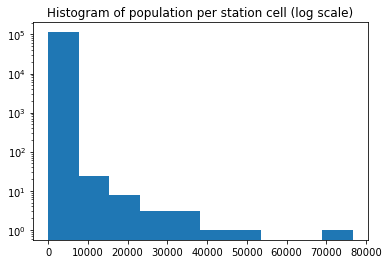

In [37]:
plt.hist(stations['pop1975'], log=True)
plt.title("Histogram of population per station cell (log scale)")
plt.show()

The cells in our population dataset are only [250x250m](https://ghsl.jrc.ec.europa.eu/ghs_pop2019.php), so to get population per km<sup>2</sup>, we actually have to multiply the number with 16 (just to make it a bit easier to compare to common measures of population density in people per km<sup>2</sup>:

In [38]:
stations['popdens1975'] = stations['pop1975'] * 16
stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450,41.143192
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427,349.350830


This list of ca. 150 of the most densely populated city *districts* globally has them all at more than 30k people per km<sup>2</sup>, how many do we have in that range?

In [39]:
print("Cells with more than 30k per sqkm: ", len(stations[stations['popdens1975'] > 30000]))
print("Cells with more than 20k per sqkm: ", len(stations[stations['popdens1975'] > 20000]))
print("Cells with more than 10k per sqkm: ", len(stations[stations['popdens1975'] > 10000]))

Cells with more than 30k per sqkm:  197
Cells with more than 20k per sqkm:  286
Cells with more than 10k per sqkm:  655


That's a small percentage, but it's what we've got, so let's roll with it.

Before we can take a look at the effect of population density on temperature, we need to get rid of the effect of elevation. We will calculate the difference in temperature (min and max) as well as the difference in elevation between each of the ca. 7 million observations in 1975 and the corresponding measurements at the nearest neighboring station (only looking at the rural stations, of course).

For that purpose, let's find the closest neighbor for each station first:

In [40]:
# add new columns to hold the ID of the nearest station and the distance to it

stations["NN"] = ""
stations["NN_dist"] = ""

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975,NN,NN_dist
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,,
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,,
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,,
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450,41.143192,,
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427,349.350830,,


Iterate through the DF and fill these columns row by row. 

🔥 **TODO** This is reeeeally slow, I'm sure there must be a faster way to do this... for now, I'm at least making sure we only need to do this once by saving the results in a CSV that can just be loaded again

In [41]:
file = 'stations_with_nearest_neighbor.csv'

if os.path.isfile(file):
    print('Nearest neighbors already computed, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    for index, row in stations.iterrows():
        nn = queryStation(row['station'], stations, stationsIndex)
        stations.loc[stations.station == row['station'], 'NN'] = nn['station'].iloc[0]
        stations.loc[stations.station == row['station'], 'NN_dist'] = nn['distance'].iloc[0]
        
    stations.to_csv('stations_with_nearest_neighbor.csv')
        
stations.head()

Nearest neighbors already computed, using local file.


,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975,NN,NN_dist
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,ACW00011647,2044.423916
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,ACW00011604,2044.423916
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,AEM00041194,15427.585565
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450,41.143192,AE000041196,15427.585565
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427,349.350830,AEM00041218,97173.049120


Now we ca move on and ...

# Get the NOAA NCDC data

Download the data from NOAA. The columns in the file are documented [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/readme.txt).

In [42]:
file = '1975.csv.gz'
if os.path.isfile(file):
    print(file, 'already downloaded.')
else:
    urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/1975.csv.gz', file)

1975.csv.gz already downloaded.


Before we can read the file, we'll define our own date parser:

In [43]:
noaadateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")


Unzip the file and load the CSV with pandas, using our date parser. We'll also give the columns names since the CSV doesn't have a header 🧟‍. This takes a few minutes:

In [44]:
with gzip.open('1975.csv.gz') as f:

    data_1975 = pd.read_csv(f, 
                            names = ["station", "date", "type", "value"],
                            usecols = [0,1,2,3],
                            parse_dates = ["date"],
                            date_parser = noaadateparser)

data_1975.head()

,station,date,type,value
0,CA008203164,1975-01-01,TMAX,17
1,CA008203164,1975-01-01,TMIN,-11
2,CA008203164,1975-01-01,PRCP,216
3,CA008203164,1975-01-01,SNOW,216
4,CA008105560,1975-01-01,TMAX,17


In [45]:
data_1975.dtypes

station            object
date       datetime64[ns]
type               object
value               int64
dtype: object

Only keep TMIN and TMAX:

In [46]:
data_1975 = data_1975[(data_1975["type"] == "TMAX") | (data_1975["type"] == "TMIN")] 
data_1975.head()

,station,date,type,value
0,CA008203164,1975-01-01,TMAX,17
1,CA008203164,1975-01-01,TMIN,-11
4,CA008105560,1975-01-01,TMAX,17
5,CA008105560,1975-01-01,TMIN,-67
10,CA007056600,1975-01-01,TMAX,-22


Join the stations to the temperature data:

In [47]:
data_1975 = pd.merge(data_1975, stations, on="station")
data_1975.head()



,station,date,type,value,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975,NN,NN_dist
0,CA008203164,1975-01-01,TMAX,17,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606
1,CA008203164,1975-01-01,TMIN,-11,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606
2,CA008203164,1975-01-02,TMAX,-11,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606
3,CA008203164,1975-01-02,TMIN,-72,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606
4,CA008203164,1975-01-03,TMAX,-11,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606


Index the dataframe by country, station, date and observation type:

In [48]:
data_1975.set_index(['country','station','date','type'], inplace=True)
data_1975.head()

value   lat    lon  elevation  \
country station     date       type                                  
CA      CA008203164 1975-01-01 TMAX     17  45.6 -60.75       15.0   
                               TMIN    -11  45.6 -60.75       15.0   
                    1975-01-02 TMAX    -11  45.6 -60.75       15.0   
                               TMIN    -72  45.6 -60.75       15.0   
                    1975-01-03 TMAX    -11  45.6 -60.75       15.0   

                                                name         mollX  \
country station     date       type                                  
CA      CA008203164 1975-01-01 TMAX  LOWER L'ARDOISE -4.874275e+06   
                               TMIN  LOWER L'ARDOISE -4.874275e+06   
                    1975-01-02 TMAX  LOWER L'ARDOISE -4.874275e+06   
                               TMIN  LOWER L'ARDOISE -4.874275e+06   
                    1975-01-03 TMAX  LOWER L'ARDOISE -4.874275e+06   

                                            mollY  pop1975  popdens1975  \
country station     date       type                                       
CA      CA008203164 1975-01-01 TMAX  5.405209e+06      0.0          0.0   
                               TMIN  5.405209e+06      0.0          0.0   
                    1975-01-02 TMAX  5.405209e+06      0.0          0.0   
                               TMIN  5.405209e+06      0.0          0.0   
                    1975-01-03 TMAX  5.405209e+06      0.0          0.0   

                                              NN      NN_dist  
country station     date       type                            
CA      CA008203164 1975-01-01 TMAX  CA008200750  14316.80606  
                               TMIN  CA008200750  14316.80606  
                    1975-01-02 TMAX  CA008200750  14316.80606  
                               TMIN  CA008200750  14316.80606  
                    1975-01-03 TMAX  CA008200750  14316.80606

Next, we will prepare the data to **correct the temperature data for elevation**. Temperature decreases with increasing altitude, so  we will try to get a hold of the nature of this relationship. To that end, we will take only rural stations (which we – somewhat arbitrarily – set at 10 people per km<sup>2</sup>; this number should be small enough to ensure that no UHI effect is influecing the measurement): 

In [49]:
print("Stations in cells with less than 10 people per sqkm: ", len(stations[stations['popdens1975'] < 10]))

Stations in cells with less than 10 people per sqkm:  73351


This should be enough, let's only take those stations:

In [50]:
rural_stations_data = data_1975[data_1975['popdens1975'] < 10]
len(rural_stations_data)

7086884